## Описание данных.

<b>Цель проекта - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.</br>

Задачи:

* Сбор данных. Промаркировать уровень финансовой активности постоянных покупателей
* Моделирование. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
* Сегментирование. Нужно выделить сегменты покупателей и разработать для них персонализированные предложения

<b> `market_file.csv` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.</b>
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

<b>`market_money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.</b>
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

<b>`market_time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.</b>
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

<b>`money.csv` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.</b>
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

## Шаг 1. Загрузка данных.

### 1.1 Импорт библиотек и загрузка данных.

In [2]:
!pip install numpy==1.26.4

In [3]:
!pip install phik -q
!pip install shap -q
!pip install -Uq scikit-learn 
!pip install -Uq matplotlib

In [4]:
# импортируем необходимые библиотеки и модули, определим константы
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
import shap
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, OneHotEncoder, 
                                   OrdinalEncoder, LabelEncoder)
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, r2_score, precision_score, recall_score,
                             roc_auc_score, f1_score)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sns.set(style='darkgrid')
sns.set(rc={'figure.figsize': (8, 3)})
sns.set_context('notebook', rc={'font.size': 14})

# константы
RS = 45  # параметр random_state (константа воспроизводимости случайных значений)
TS = 0.2  # параметр test_size (размер тестовой выборки)

In [5]:
try: 
    df_file = pd.read_csv('/datasets/market_file.csv', sep=',')
    df_money = pd.read_csv('/datasets/market_money.csv', sep=',')
    df_time = pd.read_csv('/datasets/market_time.csv', sep=',')
    df_profit = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    df_file = pd.read_csv(
        r'D:\Practicum\Git.Practicum\learning_with_a_teacher/market_file.csv', 
        sep=',')
    df_money = pd.read_csv(
        r'D:\Practicum\Git.Practicum\learning_with_a_teacher/market_money.csv', 
        sep=',')
    df_time = pd.read_csv(
        r'D:\Practicum\Git.Practicum\learning_with_a_teacher/market_time.csv', 
        sep=',')
    df_profit = pd.read_csv(
        r'D:\Practicum\Git.Practicum\learning_with_a_teacher/money.csv', 
        sep=';', 
        decimal=',')

In [6]:
df_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
df_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
df_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
df_money['Период'].value_counts()

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

In [11]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [12]:
df_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [13]:
# в значении предыдущий месяц опечатка
df_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [14]:
# устраним опечатку в значении признака "Период"
df_time['Период'] = df_time['Период'].where(df_time['Период'] != 'предыдцщий_месяц', 'предыдущий_месяц')

In [15]:
df_time.head(2)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13


In [16]:
df_profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [17]:
df_profit.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### 1.2 Проверка соответствия данных описанию.

In [18]:
# проверка сбалансированности целевого признака
df_file['Покупательская активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

Нельзя сказать, что значения целевого признака разделены поровну. Для исключения дисбаланса классов при разделении признакового описания на выборки укажем стратификацию по целевому признаку.

* В таблице `df_time` исправлена опечатка значения признака "Период".
* В таблице `df_profit` в значении признака "Прибыль" несоответствие типа данных, в качестве разделителя использована запятая (исправим в следующем шаге).
* Похоже, выручка представлена в рублях, а прибыль в тысячах рублей.

В целом предоставленные данные соответствуют описанию.

## Шаг 2. Предобработка данных.

In [19]:
# определим функцию для переименования признаков к "змеиному регистру"
def transform_col_names(data):  
    return [col.replace(' ', '_').lower() for col in data.columns]

In [20]:
# определим функцию для нахождения явных дубликатов и уникальных значений признаков
def preproc_func(data):
    print(f'Найдено {data.duplicated().sum()} явных дубликатов')
    print()
    for i in data.select_dtypes(exclude=['int', 'float']).columns:
        print(f'Признак "{i}" имеет следующие уникальные значения:')
        print(data[i].unique())
        print()

In [21]:
# приведем название признаков к "змеиному регистру"
for value in [df_file, df_money, df_time, df_profit]:
    value.columns = transform_col_names(value)

In [22]:
# для поиска явных дубликатов и анализа неявных дубликатов воспользуемся функцией
preproc_func(df_file)

Найдено 0 явных дубликатов

Признак "покупательская_активность" имеет следующие уникальные значения:
['Снизилась' 'Прежний уровень']

Признак "тип_сервиса" имеет следующие уникальные значения:
['премиум' 'стандартт' 'стандарт']

Признак "разрешить_сообщать" имеет следующие уникальные значения:
['да' 'нет']

Признак "популярная_категория" имеет следующие уникальные значения:
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



Признак "тип_сервиса" имеет неявный дубликат ("стандартт" - "стандарт").

In [23]:
# устраним неявный дубликат признака "тип_сервиса"
df_file['тип_сервиса'] = df_file['тип_сервиса'].apply(lambda x: x.replace('тт', 'т'))

In [24]:
preproc_func(df_money)

Найдено 0 явных дубликатов

Признак "период" имеет следующие уникальные значения:
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']



In [25]:
preproc_func(df_time)

Найдено 0 явных дубликатов

Признак "период" имеет следующие уникальные значения:
['текущий_месяц' 'предыдущий_месяц']



В таблице `df_profit` приведем к числовому типу признак "прибыль".

In [26]:
df_profit['прибыль'] = df_profit['прибыль'].apply(lambda x: float(x))

In [27]:
preproc_func(df_profit)

Найдено 0 явных дубликатов



In [28]:
# приведем значения признака "Прибыль" из тысяч рублей к рублям
df_profit['прибыль'] = df_profit['прибыль'] * 1000

В результате предобработки данных сделано следующее:
* названия признаков в таблицах приведены к змеиному регистру;
* устранен неявный дубликат в признаке "тип_сервиса" таблицы `df_file`;
* преобразован тип данных в значении признака "прибыль" таблицы `df_profit`.

## Шаг 3. Исследовательский анализ данных.

Проведем исследовательский анализ данных. <br> Отберем клиентов с покупательской активностью не менее трех месяцев.

In [29]:
# найдем покупателей с активностью менее трех месяцев
df_money[df_money['id'].isin(set(df_money[df_money['выручка'] == 0]['id']))]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [30]:
# удалим их из датафрейма
df_file = df_file.loc[~df_file['id'].isin(set(df_money[df_money['выручка'] == 0]['id']))].reset_index(drop=True)

### Шаг 3.1 Анализ количественных признаков.

In [31]:
# выведем описательную статистику df_file
df_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1297.0,215998.986893,374.578554,215349.00,215675.00,215999.00,216323.0,216647.00
маркет_актив_6_мес,1297.0,4.254433,1.015618,0.90,3.70,4.20,4.9,6.60
маркет_актив_тек_мес,1297.0,4.009252,0.696048,3.00,4.00,4.00,4.0,5.00
длительность,1297.0,602.993832,249.101456,121.00,410.00,607.00,806.0,1079.00
акционные_покупки,1297.0,0.320547,0.249657,0.11,0.17,0.24,0.3,0.99
средний_просмотр_категорий_за_визит,1297.0,3.267540,1.354623,1.00,2.00,3.00,4.0,6.00
неоплаченные_продукты_штук_квартал,1297.0,2.841172,1.973451,0.00,1.00,3.00,4.0,10.00
ошибка_сервиса,1297.0,4.184271,1.950973,0.00,3.00,4.00,6.0,9.00
страниц_за_визит,1297.0,8.186584,3.977061,1.00,5.00,8.00,11.0,20.00


* Из таблицы видно, что пропуски в данных отсутствуют.
* Признак "акционные_покупки" имеет среднее значение 0.32 и медиану 0.24. Возможно, присутствуют выбросы.

In [32]:
# определим функцию построения гистограммы и "ящика с усами" для анализа значений каждого признака
def hist_box_plot(data, col, bins):
    fig, ax = plt.subplots(2, figsize=(8, 5))
    fig.suptitle(f'"Ящик с усами" и гистограмма распределения признака "{col}"', fontsize=14);
    ax[0].boxplot(data.loc[:, col], vert=False)
    ax[1].hist(data[col], bins=bins)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Пользователи', fontsize=14)
    print(f'min - {data[col].describe()[3]}, max - {data[col].describe()[7]}')

In [33]:
# определим признаки с числовыми значениями таблицы 'df_file'
num_col_number = df_file.drop(['id', 'покупательская_активность'], axis=1).select_dtypes(include=('int', 'float')).columns

min - 0.9, max - 6.6


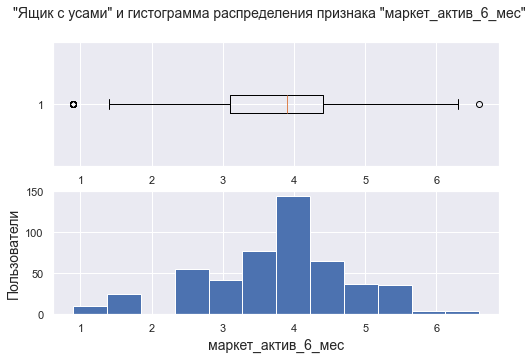

In [34]:
# построим графики для признака 'маркет_актив_6_мес' покупателей со сниженной активностью
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[0], 12)

min - 0.9, max - 6.6


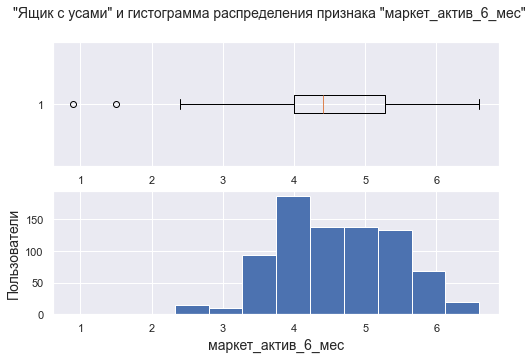

In [35]:
# построим графики для признака 'маркет_актив_6_мес' покупателей с активностью на прежнем уровне
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[0], 12)

У покупателей, чья активность снизилась, медиана и межквартильный размах среднемесячного значения маркетинговых компаний за последние 6 месяцев значительно ниже аналогичных показателей покупателей, сохранивших прежний уровень активности.

min - 3.0, max - 5.0


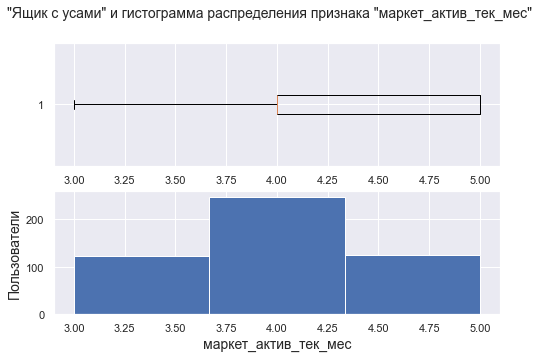

In [36]:
# построим графики для признака 'маркет_актив_тек_мес' покупателей со сниженной активностью
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[1], 3)

min - 3.0, max - 5.0


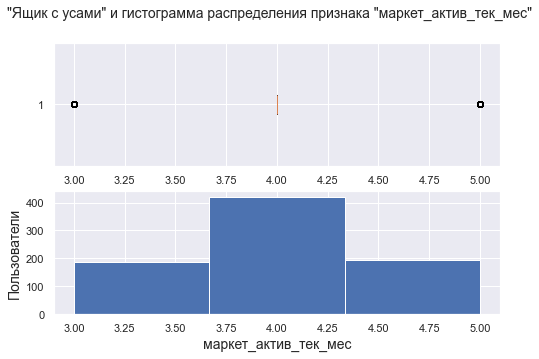

In [37]:
# построим графики для признака 'маркет_актив_тек_мес' покупателей со сниженной активностью
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[1], 3)

Распределение маркетинговой активности у групп покупателей, чья покупательская активность снизилась и осталась на прежнем уровне, совпали.<br>
Примерно 50 процентов имеют по 4 маркетинговые коммуникации в текущем месяце.<br>
По 25 процентов пользователей имеют по 3 и 5 коммуникаций.

min - 121.0, max - 1079.0


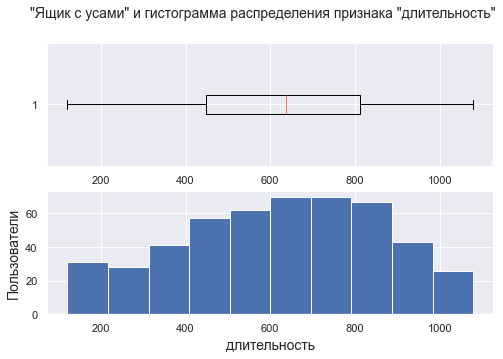

In [38]:
# построим графики для признака 'длительность' покупателей, чья активность снизилась.
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[2], 10)

min - 121.0, max - 1061.0


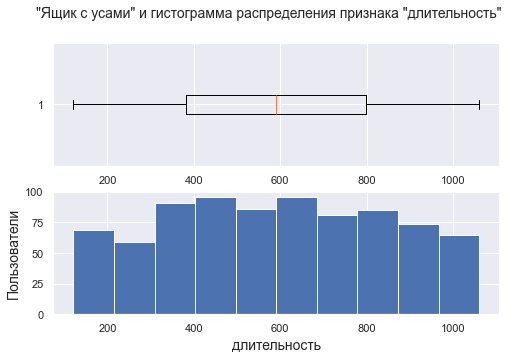

In [39]:
# построим графики для признака 'длительность' покупателей, чья активность осталась на прежнем уровне.
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[2], 10)

Минимальное количество дней регистрации - 121.
Максимальное - 1079. Аномалии и выбросы отсутствуют.

In [40]:
# выведем описательную статистику признака "акционные_покупки", сгруппировав по целевому признаку "покупательская_активность"
df_file.drop('id', axis=1).groupby('покупательская_активность')['акционные_покупки'].describe().T

покупательская_активность,Прежний уровень,Снизилась
count,802.000000,495.000000
mean,0.238367,0.453697
std,0.160599,0.304908
min,0.110000,0.110000
25%,0.150000,0.240000
50%,0.210000,0.310000
75%,0.260000,0.890000
max,0.990000,0.990000


У покупателей, сохранивших уровень активности, медиана, 1-й и 3-й квартили доли акционных товаров значительно меньше, по сравнению с покупателями, у которых активность снизилась.

min - 0.11, max - 0.99


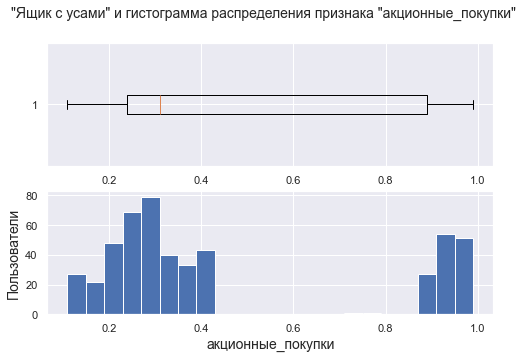

In [41]:
# построим графики для признака 'акционные_покупки' покупателей со сниженной потребительской активностью
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[3], 22)

min - 0.11, max - 0.99


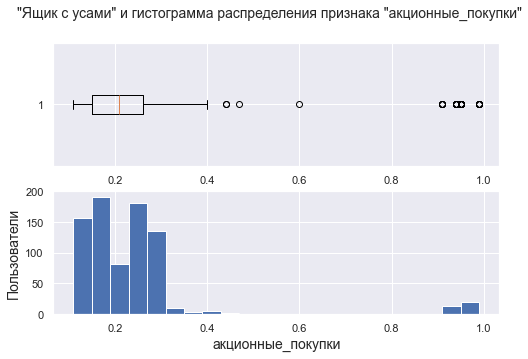

In [42]:
# построим графики для признака 'акционные_покупки' покупателей, активность которых не изменилась
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[3], 22)

Думаю, что целесообразно выделить две категории покупателей:
* Покупатели, которые стараются приобретать товар по акции (доля акционного товара более 50 процентов);
* Покупатели, чаще приобретающие обычный товар (доля акционного товара менее 50 процентов)

Можно сделать вывод, что покупатели, не снизившие покупательскую активность, в основном покупали товар без акции.
И наоборот, покупатели, снизившие активность в последнем месяце, за последние полгода покупали большое количество товаров по акции.

p.s. Значение доли в 50 процентов, по которому мы разделяем покупателей на категории, может быть изменено в дальнейшем.

In [43]:
# найдем долю покупателей с разной активностью, которые предпочитают покупать акционный товар 
# (доля акционного товара более 50 процентов)
df_file.loc[df_file['акционные_покупки'] > 0.5].groupby(
    'покупательская_активность'
    )['акционные_покупки'].count() / df_file.groupby(
    'покупательская_активность')['акционные_покупки'].count()

покупательская_активность
Прежний уровень    0.042394
Снизилась          0.270707
Name: акционные_покупки, dtype: float64

* Таким образом, среди покупателей, сохранивших прежний уровень активности, преимущественно акционный товар покупает всего 4 процента.
* Среди покупателей, активность которых снизилась, около 27 процентов предпочитают покупать преимущественно акционный товар.

Возможно, снижение активности покупателей связано с прекращением действия "акционной" цены на какой-либо товар.

min - 1.0, max - 6.0


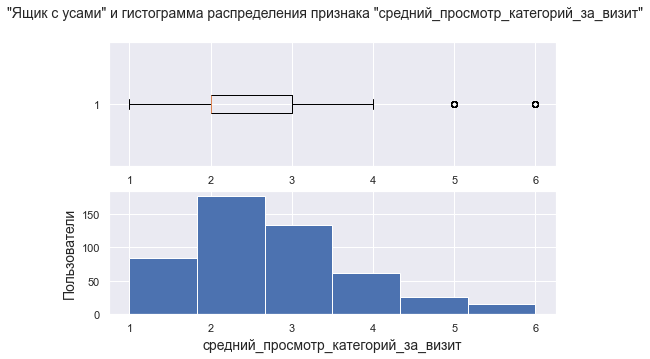

In [44]:
# построим графики для признака 'средний_просмотр_категорий_за_визит' покупателей со сниженной активностью
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[4], 6)

min - 1.0, max - 6.0


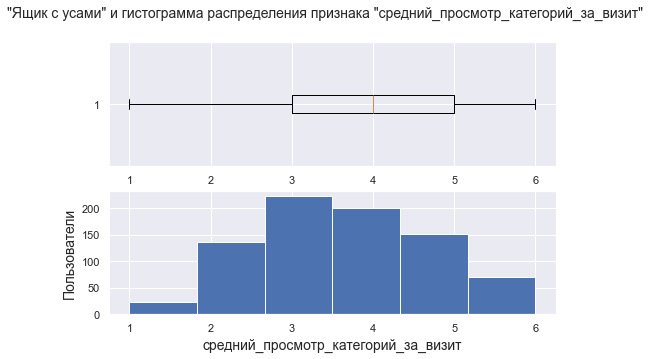

In [45]:
# построим графики для признака 'средний_просмотр_категорий_за_визит' покупателей, активность которых осталась на прежнем уровне
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[4], 6)

Очевидно, что покупатели, чья активность снизилась, просматривают меньшее количество категорий за визит (медиана 2), чем покупатели с активностью на прежнем уровне (медиана 4).

min - 0.0, max - 10.0


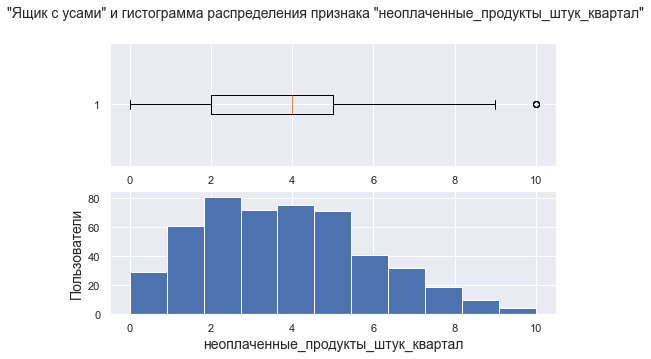

In [46]:
# построим графики для признака 'неоплаченные_продукты_штук_квартал'  покупателей со сниженной активностью
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[5], 11)

min - 0.0, max - 8.0


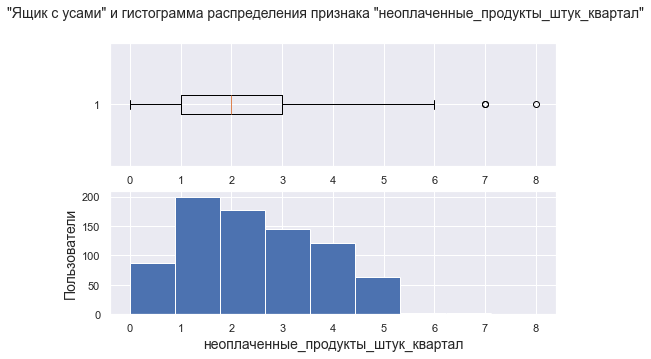

In [47]:
# построим графики для признака 'неоплаченные_продукты_штук_квартал' покупателей с активностью на прежнем уровне
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[5], 9)

Покупатели, сохранившие активность, имеют в целом меньшее количество неоплаченных товаров в корзине за последние 3 месяца, чем покупатели, активность которых снизилась.

p.s. Возможно, при оформлении заказа не применялись к выбранным товарам не применились скидки, и покупатели отказывались от покупки. Обратим внимание на распределение признаков "страниц_за_визит" и "ошибка_сервиса".

min - 1.0, max - 9.0


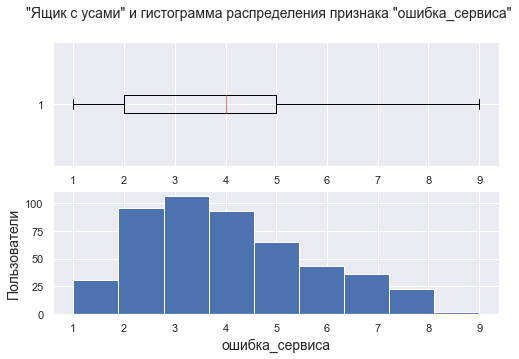

In [48]:
# построим графики для признака 'ошибка_сервиса' покупателей со сниженной активностью
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[6], 9)

min - 0.0, max - 9.0


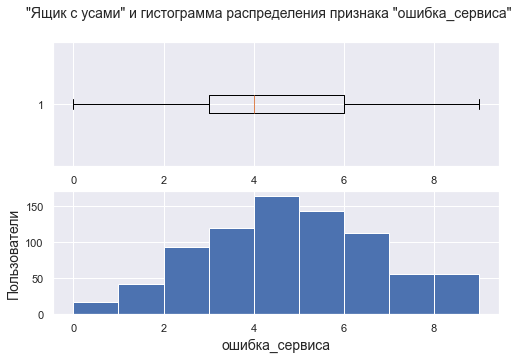

In [49]:
# построим графики для признака 'ошибка_сервиса' покупателей с прежней активностью
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[6], 9)

Предположение о том, что активность покупателей снизилась за счет ошибок ложное - медиана у двух групп покупателей равна 4, значения межквартильного размаха выше у покупателей, сохранивших прежний уровень активности.

min - 1.0, max - 18.0


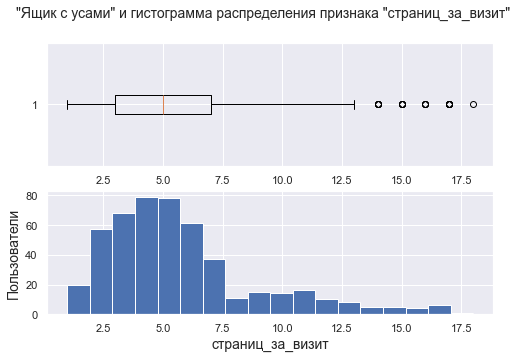

In [50]:
# построим графики для признака 'страниц_за_визит' покупателей, чья активность снизилась
hist_box_plot(df_file.query('покупательская_активность == "Снизилась"'), num_col_number[7], 18)

min - 3.0, max - 20.0


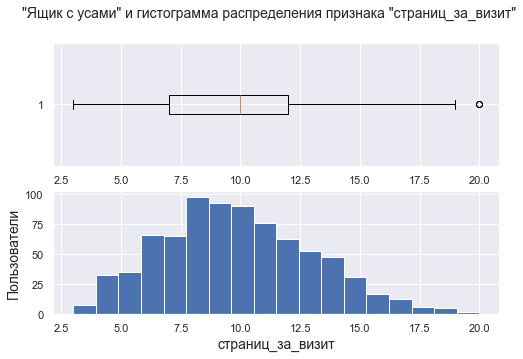

In [51]:
# построим графики для признака 'страниц_за_визит' покупателей, сохранивших активность
hist_box_plot(df_file.query('покупательская_активность != "Снизилась"'), num_col_number[7], 18)

* Покупатели, снизившие активность, просмотрели в среднем меньшее количество страниц, причём основная масса таких покупателей смотрела не больше 7-ми страниц.
* Большинство пользователей, сохранивших активность, напротив, в среднем просматривают от 8-ми (мода) до 20-ти страниц (количество пользователей постепенно уменьшается)

In [52]:
# выведем описательную статистику df_money
df_money.drop('id', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


Максимальное значение похоже на выброс.

min - 0.0, max - 106862.2


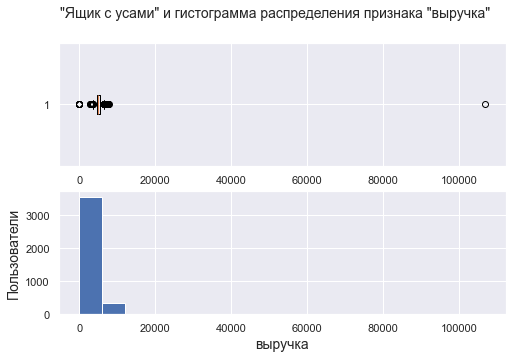

In [53]:
# построим графики для признака 'выручка' таблицы 'df_money'
hist_box_plot(df_money, 'выручка', 18)

In [54]:
# найдем выручку по месяцам у этого покупателя
df_money[df_money['id'] == df_money.loc[df_money['выручка'].idxmax(), 'id']]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


Удалим данные об этом пользователе из `df_money`

In [55]:
df_money = df_money.query('id != 215380').reset_index(drop=True)

min - 0.0, max - 7799.4


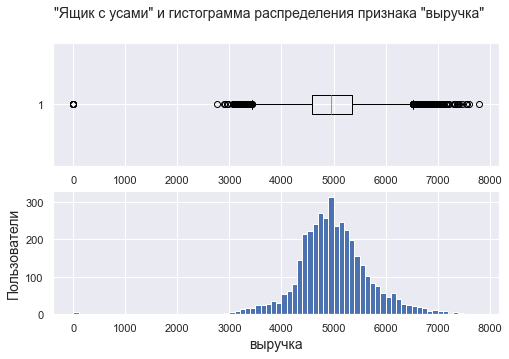

In [56]:
# снова построим графики для признака 'выручка' таблицы 'df_money'
hist_box_plot(df_money, 'выручка', 78)

Распределение похоже на нормальное, возможен выброс у нуля.

In [57]:
# найдем выручку по месяцам у этого покупателя
df_money[df_money['id'] == df_money.loc[df_money['выручка'].idxmin(), 'id']]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


Оставим информацию об этом пользователе в датафрейме, так как в текущем месяце у него все-таки были покупки.

In [58]:
# выведем описательную статистику df_time
df_time.drop('id', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
минут,2600.0,13.336154,4.080198,4.0,10.0,13.0,16.0,23.0


min - 4.0, max - 23.0


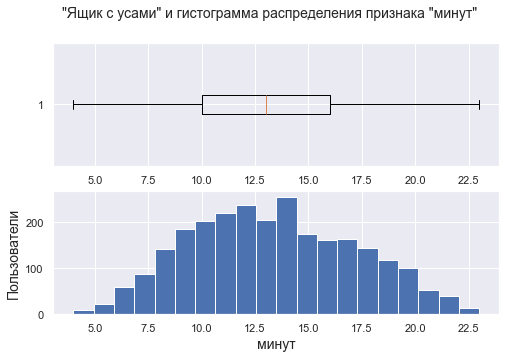

In [59]:
hist_box_plot(df_time, 'минут', 20)

В среднем пользователи проводят на сайте от 7-ми до 20-ти минут. Выбросы и аномалии не найдены.

In [60]:
# выведем описательную статистику df_profit
df_profit.drop('id', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
прибыль,1300.0,3996.630769,1013.722112,860.0,3300.0,4045.0,4670.0,7430.0


min - 860.0, max - 7430.0


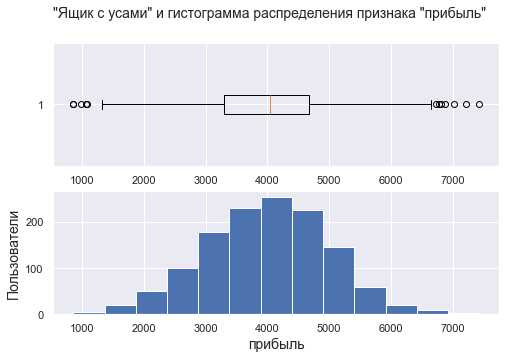

In [61]:
hist_box_plot(df_profit, 'прибыль', 13)

Гистограмма прибыли не показала нам выбросов или аномалий. Медиана чуть больше 4000 руб.

### Шаг 3.2 Анализ категориальных признаков.

In [62]:
# категориальные признаки df_file
df_file.select_dtypes(exclude=['int', 'float']).head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
0,Снизилась,премиум,да,Товары для детей
1,Снизилась,стандарт,нет,Домашний текстиль
2,Снизилась,стандарт,да,Товары для детей
3,Снизилась,стандарт,нет,Товары для детей
4,Снизилась,стандарт,да,Домашний текстиль


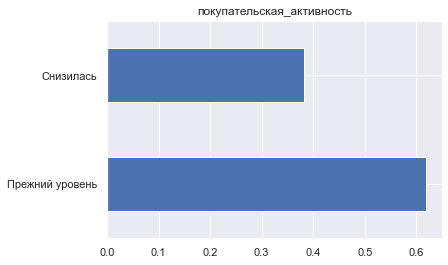

In [63]:
# целевой признак "покупательская_активность"

df_file.select_dtypes(
    exclude=['int', 'float']
    )['покупательская_активность'].value_counts(normalize=True).plot.barh();
plt.title('покупательская_активность');

Признак "покупательская_активность" распределился следующим образом: покупатели, сохранившие прежний уровень, составляют около 60 процентов от общего числа. Остальные 40 процентов - покупатели, активность которых снизилась.

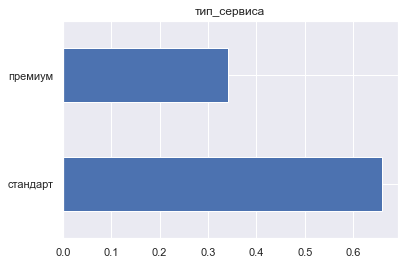

In [64]:
# построим график для признака 'тип_сервиса' покупателей, чья активность снизилась
df_file.query('покупательская_активность == "Снизилась"')['тип_сервиса'].value_counts(
    normalize=True).plot.barh();
plt.title('тип_сервиса');

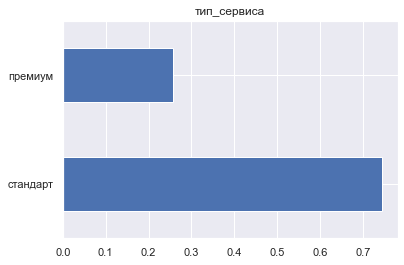

In [65]:
# построим график для признака 'тип_сервиса' покупателей с прежним уровнем активности
df_file.query('покупательская_активность != "Снизилась"')['тип_сервиса'].value_counts(
    normalize=True).plot.barh();
plt.title('тип_сервиса');

Покупатели, сохранившие активность на прежнем уровне, реже пользуются подпиской премиум.

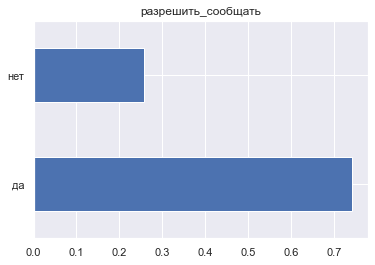

In [66]:
# построим график для признака 'разрешить_сообщать' покупателей, чья активность снизилась
df_file.query('покупательская_активность == "Снизилась"')['разрешить_сообщать'].value_counts(
    normalize=True).plot.barh();
plt.title('разрешить_сообщать');

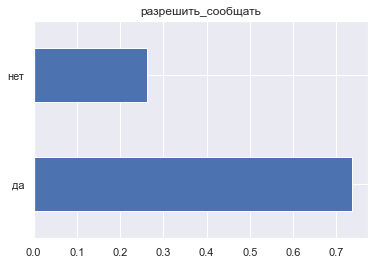

In [67]:
# построим график для признака 'разрешить_сообщать' покупателей с прежним уровнем активности
df_file.query('покупательская_активность != "Снизилась"')['разрешить_сообщать'].value_counts(
    normalize=True).plot.barh();
plt.title('разрешить_сообщать');

Больше 70 процентов пользователей, независимо от покупательской активности, дают согласие на рассылку дополнительных предложений о товаре

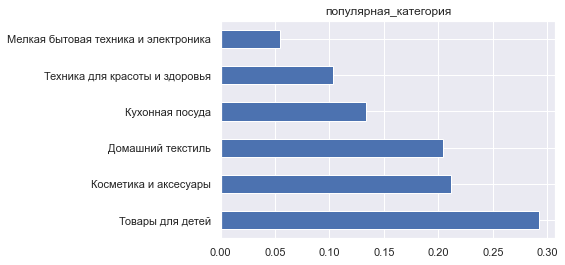

In [68]:
# построим график для признака 'разрешить_сообщать' покупателей, чья активность снизилась
df_file.query('покупательская_активность == "Снизилась"')['популярная_категория'].value_counts(
    normalize=True).plot.barh()
plt.title('популярная_категория');

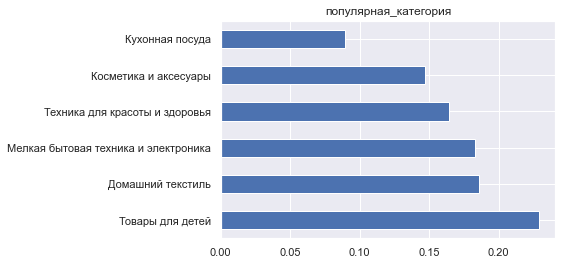

In [69]:
# построим график для признака 'разрешить_сообщать' покупателей с прежним уровнем активности
df_file.query('покупательская_активность != "Снизилась"')['популярная_категория'].value_counts(
    normalize=True).plot.barh()
plt.title('популярная_категория');

Самой популярной категорией в обеих групп покупателей стала категория "Товары для детей" (почти 30 процентов пользователей, у которых активность снизилась, отдали ей предпочтение).<br>
Далее категории распределились по-разному, в зависимости от покупательской активности.</br>
Стоит отметить, что категория "Косметика и аксессуары" у пользователей, чья активность снизилась, оказалась на 2-м месте, тогда как у пользователей, сохранивших активность, стала предпоследней по популярности.

### Шаг 3.3 Вывод

<b>В результате исследовательского анализа выявлено следующее:
    
* У покупателей, чья активность снизилась, медиана и межквартильный размах среднемесячного значения маркетинговых компаний за последние 6 месяцев значительно ниже аналогичных показателей покупателей, сохранивших прежний уровень активности.
* У покупателей, сохранивших уровень активности, медиана, 1-й и 3-й квартили доли акционных товаров значительно меньше, по сравнению с покупателями, у которых активность снизилась.

* Существуют две категории покупателей:
    * Покупатели, которые стараются приобретать товар по акции (доля акционного товара более 50 процентов);
    * Покупатели, чаще приобретающие обычный товар (доля акционного товара менее 50 процентов)

Возможно, покупатели, не снизившие покупательскую активность, в основном покупали товар без акции.
И наоборот, покупатели, снизившие активность в последнем месяце, за последние полгода покупали большое количество товаров по акции.
* Очевидно, что покупатели, чья активность снизилась, просматривают меньшее количество категорий за визит (медиана 2), чем покупатели с активностью на прежнем уровне (медиана 4).
* Покупатели, сохранившие активность, имеют в целом меньшее количество неоплаченных товаров в корзине за последние 3 месяца, чем покупатели, активность которых снизилась.
* Покупатели, снизившие активность, просмотрели в среднем меньшее количество страниц, причём основная масса таких покупателей смотрела не больше 7-ми страниц. Напротив, большинство пользователей, сохранивших активность, напротив, в среднем просматривают от 8-ми (мода) до 20-ти страниц (количество пользователей постепенно уменьшается). При этом, число сбоев, которые коснулись покупателя покупателей во время посещения сайта, в целом не зависит от уровня покупательской активности.
* Удален выброс в признаке "выручка". 
* Покупатели, сохранившие активность на прежнем уровне, реже пользуются подпиской премиум.
* Больше 70 процентов пользователей, независимо от покупательской активности, дают согласие на рассылку дополнительных предложений о товаре.

## Шаг 4. Объединение таблиц.

Объединим таблицы `market_file.csv`, `market_money.csv`, `market_time.csv` в итоговую таблицу `df_united`

In [70]:
# выведем размерность исходных таблиц
df_file.shape, df_money.shape

((1297, 13), (3897, 3))

In [71]:
# объединим данные
for value in ['текущий_месяц', 'предыдущий_месяц', 'препредыдущий_месяц']:
    df_file = df_file.merge(
        df_money.loc[df_money['период'] == value, ['id', 'выручка']], 
        on='id', 
        how='inner'
    ).rename(columns={'выручка': 'выручка_' + value})

In [72]:
# выведем размерность полученной таблицы
df_file.shape

(1296, 16)

In [73]:
# объединим данные
for value in df_time['период'].unique():
    df_file = df_file.merge(
        df_time.loc[df_time['период'] == value, ['id', 'минут']], 
        on='id', 
        how='inner'
    ).rename(columns={'минут': 'минут_' + value})

In [74]:
# определим новый датафрейм с объединенными данными
df_united = df_file.copy()

In [75]:
df_united.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


## Шаг 5. Корреляционный анализ.

Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования.

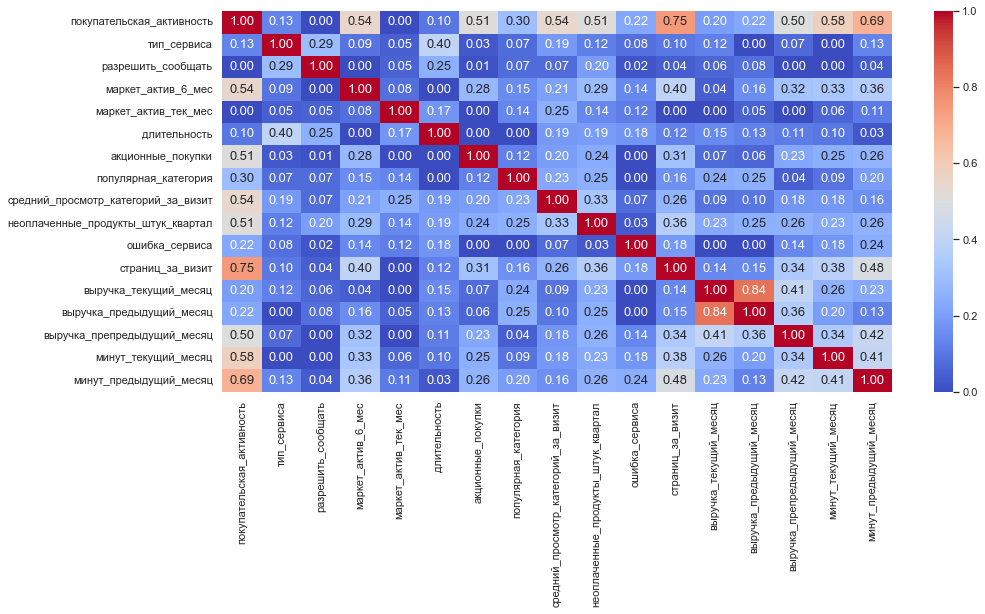

In [76]:
# построим тепловую карту для матрицы корреляции с помощью библиотеки phik
plt.figure(figsize=(15, 7))
corr_matrix = df_united.drop('id', axis=1).phik_matrix(verbose=False)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', annot_kws={'size': 13}, cmap='coolwarm');

Целевой признак "покупательская_активность" имеет сильные корреляционные связи со следующими входными признаками:
* "страниц_за_визит" - 0.75
* "минут_предыдущий_месяц" - 0.69
* "минут_текущий_месяц" - 0.58

Целевой признак "покупательская_активность" имеет умеренные корреляционные связи со следующими входными признаками:
* "маркет_актив_6_мес" и "средний_просмотр_категорий_за_визит" - 0.54
* "акционные_покупки" и "неоплаченные_продукты_штук_квартал" - 0.51
* "популярная_категория" - 0.3

Однако, не стоит забывать, что корреляция между входным и целевым признаком еще не подтверждает факт наличия причинно-следственной связи. <br>
Входные признаки "выручка_предыдущий_месяц" и "выручка_текущий_месяц" очень сильно коррелируют между собой (коэф. корреляции Фи 0.84).

## Шаг 6. Использование пайплайнов.

In [77]:
# определим признаковое описание входных и целевого признаков
X = df_united.drop(['id', 'покупательская_активность'], axis=1)
y = df_united['покупательская_активность']

# кодируем целевой признак
y = LabelEncoder().fit_transform(y)

# определим переменные с названием количественных и категориальных признаков
cat_col_names = X.select_dtypes(exclude=['int', 'float']).columns.to_list()
num_col_names = X.select_dtypes(include=['int', 'float']).columns.to_list()

# разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TS, random_state=RS, stratify=y)

In [78]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', sparse_output=False))
    ]
)

In [79]:
# пайплайн для кодирования категориальных признаков и стандартизации количественных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col_names),
        ('num', StandardScaler(), num_col_names)
    ],
    remainder='passthrough'
)

In [80]:
# финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RS))
    ]
)

In [81]:
# определяем список словарей для каждой модели с гипрепараметрами
param_grid = [
    # DecisionTreeClassifier()
    {
        'model': [DecisionTreeClassifier(random_state=RS)],
        'model__max_depth': range(2, 6),
        'model__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),  'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()]
    },
    # KNeighborsClassifier()     
    {
        'model': [KNeighborsClassifier()],        
        'model__n_neighbors': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()]
    },
    # LogisticRegression()    
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RS)],
        'model__C': range(1, 5),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()]
    },

    # SVC()
    {
        'model': [SVC(probability=True, random_state=RS)],
        # параметры подбора ядра (закомментировал два ядра для экономии времени расчета модели)
        'model__kernel': ['poly', 'rbf'],  #, 'sigmoid', 'linear'],
        'preprocessor__num': [StandardScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder()]
}
]

In [82]:
# инициализация поиска модели и гиперпараметров по сетке с кросс-валидацией
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

Оптимальной метрикой в нашем случае является `roc_auc`, позволяющая оценить модель независимо от пороговых значений даже при дисбалансе классов.

In [83]:
grid.fit(X_train, y_train)

C:\anaconda3\envs\notebook\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать',
                                                                          'популярная_категория']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['маркет_актив_6_мес',
                                                                          'маркет_актив_тек_мес',
                                                                          'длительность',
                                                                          'акционн...
                                                       solver='liblinear')],
                          'model__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), 'passthrough'],
                          'preprocessor__ohe': [OneHotEncoder()]},
                         {'model': [SVC(probability=True, random_state=45)],
                          'model__kernel': ['poly', 'rbf'],
                          'preprocessor__num': [StandardScaler(),
                                                'passthrough'],
                          'preprocessor__ohe': [OneHotEncoder(),
                                                OrdinalEncoder()]}],
             scoring='roc_auc')

In [84]:
# лучшая модель
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_текущий_месяц',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'минут_текущий_месяц',
                                                   'минут_предыдущий_месяц'])])),
                ('model', SVC(probability=True, random_state=45))])

In [85]:
# лучшие параметры модели
grid.best_params_

{'model': SVC(probability=True, random_state=45),
 'model__kernel': 'rbf',
 'preprocessor__num': StandardScaler(),
 'preprocessor__ohe': OneHotEncoder()}

In [86]:
# лучшее среднее значение метрики roc_auc при кросс-валидации
grid.best_score_

0.9080778996173094

In [87]:
# найдем метрику "roc_auc" на вероятностях классов
roc_auc_proba = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])
print('Площадь ROC-кривой:', roc_auc_proba)

Площадь ROC-кривой: 0.9448522492000753


* Таким образом, лучшая модель базируется <b>на методе опорных векторов (SVC())</b>, c кодировщиком <b>`OneHotEncoder()`</b>, стандартизирующая количественные признаки с помощью `StandardScaler()`.
*Метрика <b>`roc_auc_score`</b> лучшей модели на тестовой выборке (random_state=45, test_size=0.2) <b>равна 0.945.

In [88]:
# установим максимальную ширину столбца датафрейма
pd.set_option('display.max_colwidth', None)

In [89]:
# выведем тройку лучших моделей с гиперпараметрами
pd.DataFrame(
    list(grid.cv_results_.values()), 
    list(grid.cv_results_.keys())
).T.sort_values(by='rank_test_score').head(3)#.loc[: ,['param_model', 'param_preprocessor__num', 
                                               #       'param_preprocessor__ohe', 'param_model__C', 
                                               #       'params', 'rank_test_score']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_preprocessor__num,param_preprocessor__ohe,param_model__n_neighbors,...,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
124,0.350474,0.089579,0.03818,0.011713,"SVC(probability=True, random_state=45)",--,--,StandardScaler(),OneHotEncoder(),--,...,rbf,"{'model': SVC(probability=True, random_state=45), 'model__kernel': 'rbf', 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': OneHotEncoder()}",0.893435,0.923259,0.928797,0.886175,0.908722,0.908078,0.016458,1
125,0.270123,0.02665,0.045893,0.019057,"SVC(probability=True, random_state=45)",--,--,StandardScaler(),OrdinalEncoder(),--,...,rbf,"{'model': SVC(probability=True, random_state=45), 'model__kernel': 'rbf', 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': OrdinalEncoder()}",0.896379,0.930479,0.92771,0.880439,0.901899,0.907381,0.019098,2
120,0.210793,0.013766,0.017346,0.007475,"SVC(probability=True, random_state=45)",--,--,StandardScaler(),OneHotEncoder(),--,...,poly,"{'model': SVC(probability=True, random_state=45), 'model__kernel': 'poly', 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': OneHotEncoder()}",0.907075,0.929984,0.923556,0.870748,0.892306,0.904734,0.02148,3


* на втором месте модель <b>SVC</b>(probability=True, random_state=45,<b> model='rbf'</b>, StandardScaler(), <b>OrdinalEncoder()</b>);
* третье место так же заняла модель <b>SVC</b>(probability=True, random_state=45,<b> model='poly'</b>, StandardScaler(), <b>OneHotEncoder()</b>)

## Шаг 7. Анализ важности признаков.

### Шаг 7.1 Оценка важность признаков для лучшей модели и построение графика важности с помощью метода SHAP

In [90]:
# инициализируем лучшую модель
model = grid.best_estimator_['model']

In [91]:
# обучаем модель на кодированных и масштабированных данных тренировочной выборки
model.fit(data_preprocessor.fit_transform(X_train), y_train)

SVC(probability=True, random_state=45)

In [92]:
# определяем "explainer"
explainer = shap.KernelExplainer(
    # передаем в "explainer" обученную на трансформированной тренировочной выборке модель
    model.decision_function, 
    # и 5 кластеров тренировочной выборки
    shap.kmeans(data_preprocessor.fit_transform(X_train), 5)
)

In [93]:
# трансформируем тренировочную выборку
X_test_new = pipe_final.named_steps['preprocessor'].transform(X_test)

In [94]:
# попытка получить массив названий признаков
# код падает с ошибкой
X_test_new = pd.DataFrame(
    X_test_new, 
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

In [95]:
shap_values = explainer(X_test_new)

  0%|          | 0/260 [00:00<?, ?it/s]

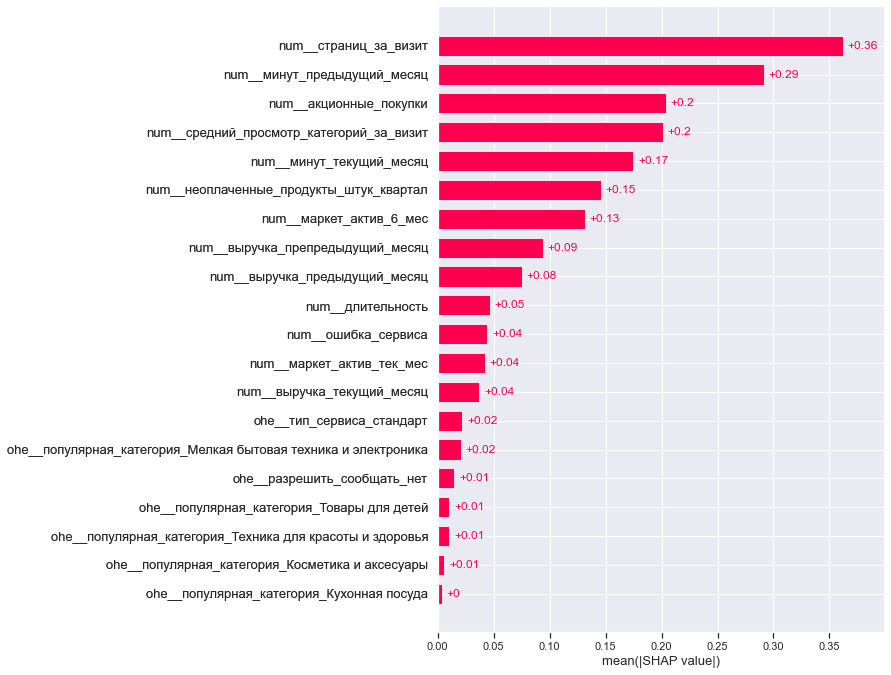

In [96]:
# столбчатая диаграмма общего вклада признаков в прогнозы модели
shap.plots.bar(shap_values, max_display=20)

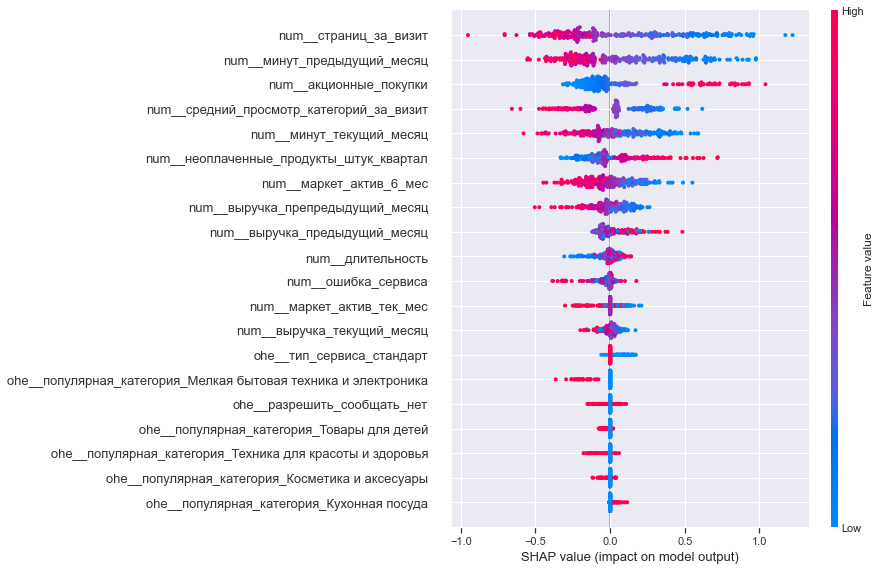

In [97]:
# диаграмма вклада признаков в каждое предсказание модели
shap.plots.beeswarm(shap_values, max_display=20)

### Шаг 7.2 Выводы о значимости признаков.

Признаки <b>"популярная_категория", "разрешить_сообщать", "тип_сервиса"</b> оказывают незначительное влияние на целевой признак. 
* В результате корреляционного анализа признака <b>"тип_сервиса" (коэф.корр. 0), "разрешить_сообщать" (коэф.корр. 0.13)</b> практически не влияли на целевой признак, однако, признак <b>"популярная_категория" (коэф.корр.0.3)</b> был выделен в число признаков с умеренным влиянием на покупательскую активность.
* В исследовательской анализе признака <b>"тип_сервиса"</b> было отмечено, что покупатели, сохранившие активность на прежнем уровне, реже пользуются подпиской премиум. Из диаграммы видно, что чем больше значение коэф. SHAP (вероятность принадлежности к классу 1 - активность снизилась), тем ниже вероятность стандартной подписки 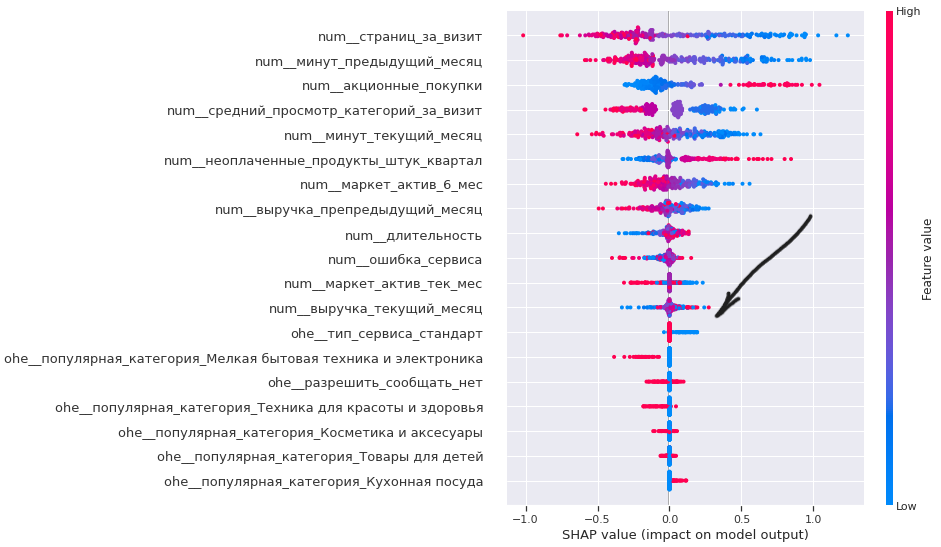 В результате исследовательского анализа был сделан вывод, что признак <b>"разрешить_сообщать"</b> не оказывает влияние на целевой признак. <br>

Сильнее всего влияют на покупательскую активность признаки "страниц_за_визит", "минут_предыдущий_месяц" (в корр. анализе отмечены, как признаки с самой сильной связью), "акционные_покупки", "средний_просмотр_категорий_за_визит", "минут_текущий_месяц", "неоплаченные_продукты_штук_квартал", "маркет_актив_6_мес".<br>
* <b>"страниц_за_визит", "минут_предыдущий_месяц"</b> С ростом значений этих признаков снижается вероятность отнесения к классу 1 (активность снизилась). Ранее отмечалось, что покупатели, снизившие активность, просматривают меньшее количество страниц за визит.
* <b>"акционные_покупки", "неоплаченные_продукты_штук_квартал"</b> Чем большее значение имеют эти признаки тем больше вероятность отнесения к классу 1 (покупательская активность снизилась). В исследовательском анализе отмечалось, что покупатели, сохранившие покупательскую активность, в основном покупали товар без акции. И наоборот, покупатели, снизившие активность, за последние полгода покупали большое количество товаров по акции. Было замечено, что у покупателей, сохранивших активность, меньше неоплаченных продуктов.
* <b>"средний_просмотр_категорий_за_визит"</b>  Покупатели, чья активность снизилась, просматривают меньшее количество категорий за визит, чем покупатели с активностью на прежнем уровне (чем меньше значение этого признака, тем больше вероятность отнесения к классу 1).
* <b>"маркет_актив_6_мес"</b>  У покупателей, чья активность снизилась, медиана и межквартильный размах среднемесячного значения маркетинговых компаний за последние 6 месяцев значительно ниже аналогичных показателей покупателей, сохранивших прежний уровень активности, то есть в среднем наблюдалась меньшая маркетинговая активность (чем меньше значение этого признака, тем больше вероятность отнесения к классу 1).

<b>При моделировании и принятии бизнес-решений мы не можем повлиять на показатели количества страниц, просмотренных покупателем за визит, количества минут нахождения на сайте или количества просмотренных категорий (на диаграмме - признаки, относящиеся к поведению на сайте).<br>
Однако, есть возможность повлиять на показатели других признаков:
    
* Коммуникации с клиентом. Необходимо продумать структуру, определяющую маркетинговую активность (звонки, рассылки).
* Продуктовое поведение. Пересмотр подхода к анализу предпочтений клиента на основании структуры его заказов.
* Финансовое поведение. Разработка системы рекомендаций товара клиенту, бонусной программы постоянным покупателям.
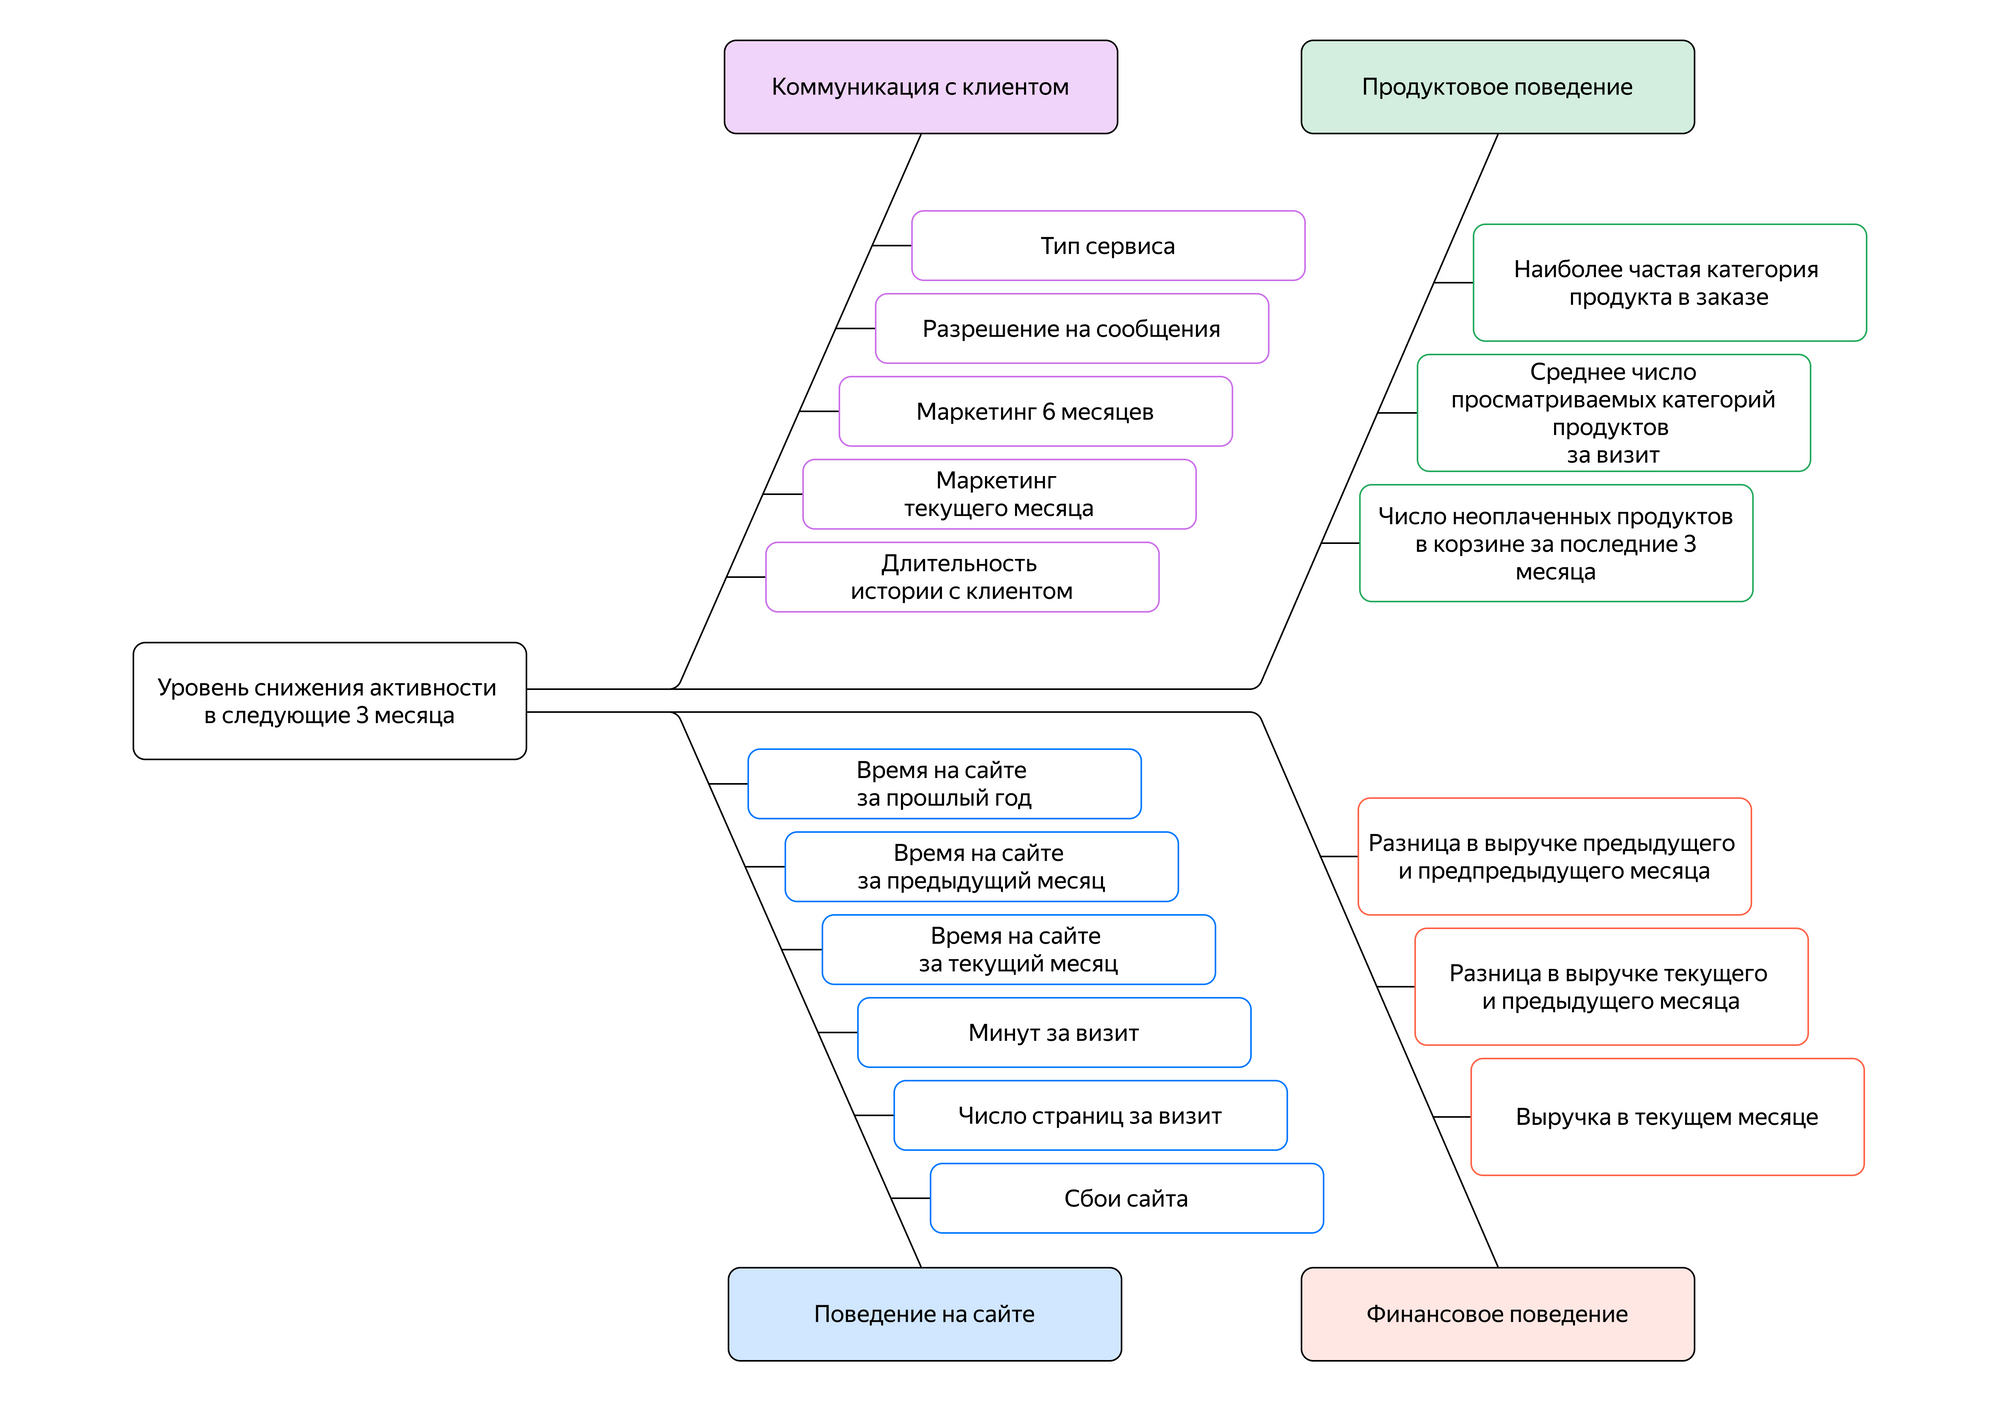

### Шаг 7.3 Корректировка признакового описания. Удаление признаков с низкой корреляцией

Внесем изменения в пайплайн. Уберем кодирование категориальных признаков

In [102]:
# уберем кодирование категориальных признаков
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col_names)
    ],
    remainder='passthrough'
)

In [103]:
# финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RS))
    ]
)

In [104]:
# определяем список словарей для каждой модели с гипрепараметрами
param_grid = [
    # DecisionTreeClassifier()
    {
        'model': [DecisionTreeClassifier(random_state=RS)],
        'model__max_depth': range(2, 6),
        'model__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),  'passthrough']
    },
    # KNeighborsClassifier()     
    {
        'model': [KNeighborsClassifier()],        
        'model__n_neighbors': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    },
    # LogisticRegression()    
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RS)],
        'model__C': range(1, 5),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    },

    # SVC()
    {
        'model': [SVC(probability=True, random_state=RS)],
        # параметры подбора ядра (закомментировал два ядра для экономии времени расчета модели)
        'model__kernel': ['poly', 'rbf'],  #, 'sigmoid', 'linear'],
        'preprocessor__num': [StandardScaler(), 'passthrough']
}
]

In [105]:
X_train_new = pd.DataFrame(
    data_preprocessor.fit_transform(X_train[num_col_names]), 
    columns=data_preprocessor.get_feature_names_out()
)
X_test_new = pd.DataFrame(
    data_preprocessor.fit_transform(X_test[num_col_names]),
    columns=data_preprocessor.get_feature_names_out()
)

In [107]:
# инициализация поиска модели и гиперпараметров по сетке с кросс-валидацией
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [117]:
pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', ascending=False).iloc[:, [4, 11, 17, 19]].head(3)

,param_model,params,mean_test_score,rank_test_score
74,"SVC(probability=True, random_state=45)","{'model': SVC(probability=True, random_state=45), 'model__kernel': 'rbf', 'preprocessor__num': StandardScaler()}",0.908490,1
61,"LogisticRegression(penalty='l1', random_state=45, solver='liblinear')","{'model': LogisticRegression(penalty='l1', random_state=45, solver='liblinear'), 'model__C': 1, 'preprocessor__num': MinMaxScaler()}",0.896111,2
64,"LogisticRegression(penalty='l1', random_state=45, solver='liblinear')","{'model': LogisticRegression(penalty='l1', random_state=45, solver='liblinear'), 'model__C': 2, 'preprocessor__num': MinMaxScaler()}",0.895853,3


In [108]:
grid.fit(X_train[num_col_names], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['маркет_актив_6_мес',
                                                                          'маркет_актив_тек_мес',
                                                                          'длительность',
                                                                          'акционные_покупки',
                                                                          'средний_просмотр_категорий_за_визит',
                                                                          'неоплаченные_продукты_штук_квартал',
                                                                          'ошибка_сервиса',
                                                                          'страниц_за_визит',
                                                                          'выручка_текущий_ме...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'model': [LogisticRegression(penalty='l1',
                                                       random_state=45,
                                                       solver='liblinear')],
                          'model__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'model': [SVC(probability=True, random_state=45)],
                          'model__kernel': ['poly', 'rbf'],
                          'preprocessor__num': [StandardScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [109]:
grid.best_score_

0.9084898746442939

<b>Среднее значение метрики `roc_auc_score` на тренировочной выборке выросло на 0.004

In [110]:
roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test[num_col_names])[:, 1])

0.9396448961666354

<b>Но упало на тестовой почти на 0.005

<b>Вывод: исключение категориальных признаков с низким влиянием на целевую переменную из признакового описания не дает прироста качества работы модели.

## Шаг 8. Сегментация покупателей.

In [98]:
# объединим данные о покупателях с их прибылью
df_full = df_file.merge(df_profit, on='id', how='inner').copy()

In [99]:
# размер после добавления данных о прибыли
df_full.shape

(1296, 19)

In [100]:
X_full = df_full.drop(['id', 'покупательская_активность'], axis=1)

In [101]:
# добавим данные о вероятности отнесения к классу
df_full['вероятность'] = pd.Series(grid.best_estimator_['model'].predict_proba(
    pipe_final.named_steps['preprocessor'].transform(X_full))[:, 1])

In [102]:
# размер после добавления столбца "вероятность"
df_full.shape

(1296, 20)

В исследовательском анализе мы пришли к выводу, что есть две категории покупателей: предпочитающие акционные товары и обычные покупатели.

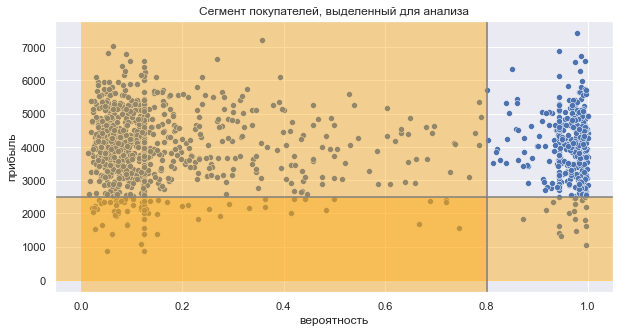

In [103]:
# определим сегмент покупателей с высокой вероятностью 
# снижения покупательской активности и хорошей прибылью
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_full, x='вероятность', y='прибыль')
plt.title('Сегмент покупателей, выделенный для анализа')
plt.axhline(y=2500, color='grey')
plt.axvline(x=0.8, color='grey');
plt.axvspan(xmin=0, xmax=0.8, color='orange', alpha=0.4)
plt.axhspan(ymin=0, ymax=2500, color='orange', alpha=0.4);

In [104]:
# определим сегмент покупателей акционных товаров с высокой вероятностью снижения 
# покупательской активности и прибылью более 2500
target_cat = df_full[
    (df_full['вероятность'] > 0.8) &
    (df_full['прибыль'] > 2500) &
    (df_full['акционные_покупки'] > 0.8)
    
]

target_cat.shape[0]

108

Данный сегмент покупателей нельзя терять, они приносит хорошую прибыль сервису. Необходимо провести анализ поведения покупателей для корректировки стратегии удержания клиента.

In [105]:
# определим сегмент постоянных покупателей
other_customers = df_full.loc[~df_full['id'].isin(target_cat['id'])].query('вероятность < 0.8')
other_customers.shape[0]

921

Таким образом, у нас есть сегмент покупателей товаров по скидке (108 чел.) и сегмент остальных покупателей (921 чел.)

In [106]:
# сбросим индексы
target_cat = target_cat.reset_index(drop=True)
other_customers = other_customers.reset_index(drop=True)

In [107]:
# определим функцию для построения гистограмм
def plot_2hist(col):
    plt.figure(figsize=(8, 4))
    plt.title(col)
    plt.hist(other_customers[col], color='grey', label='активные покупатели')
    plt.show;
    plt.hist(target_cat[col], alpha=0.6, label='любители скидок')
    plt.show;
    plt.legend()

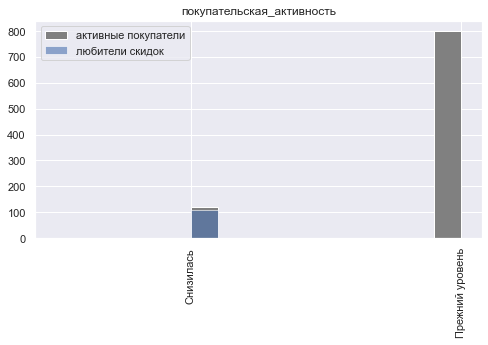

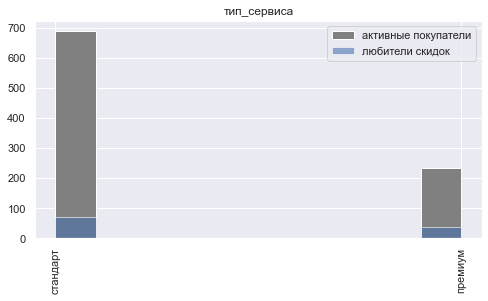

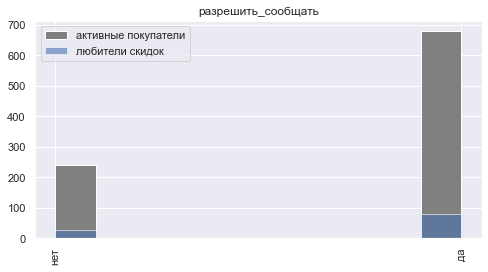

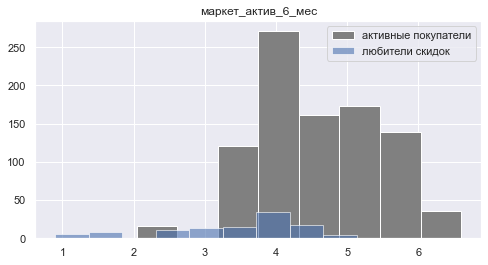

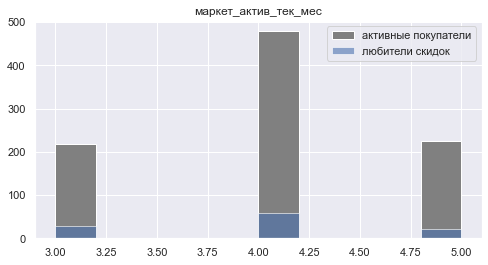

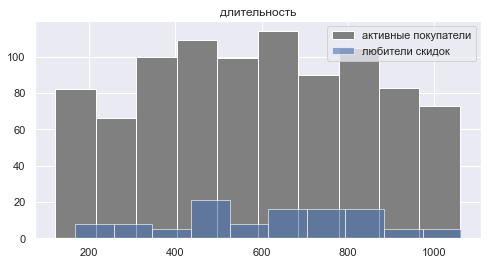

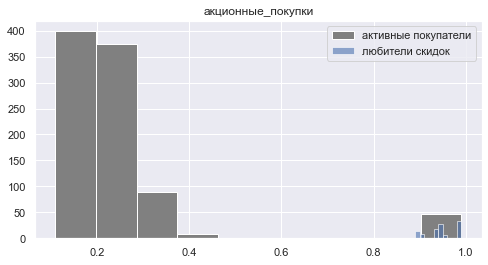

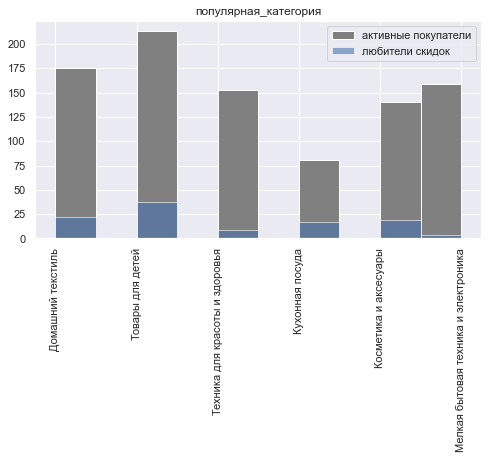

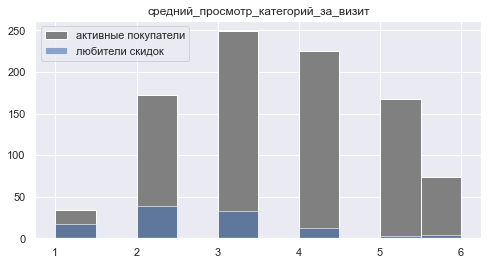

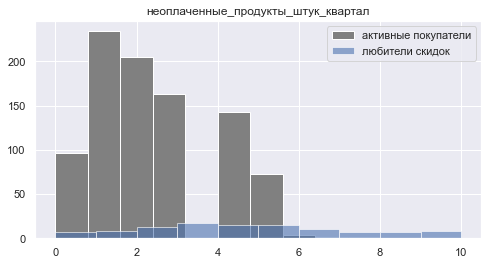

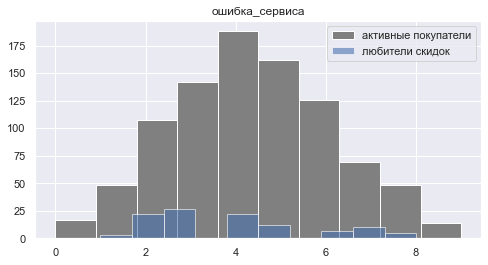

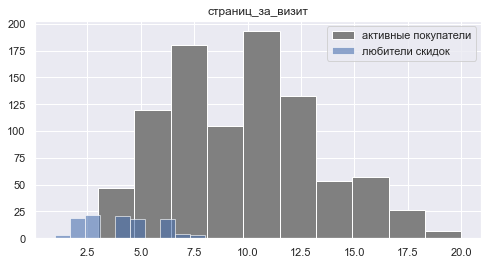

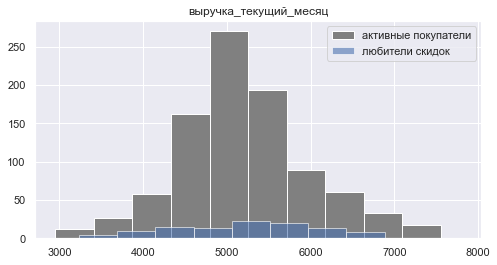

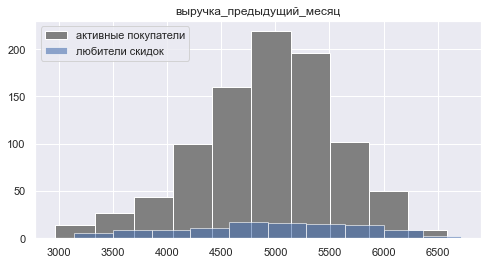

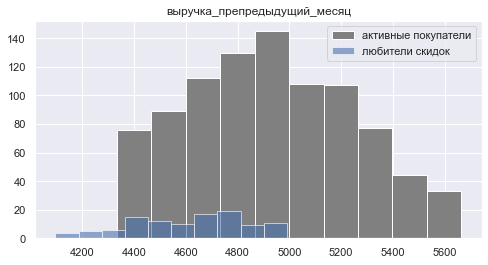

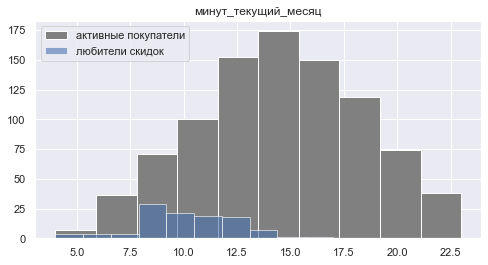

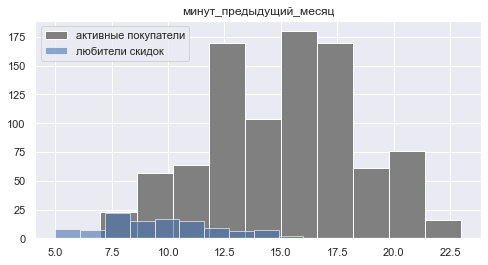

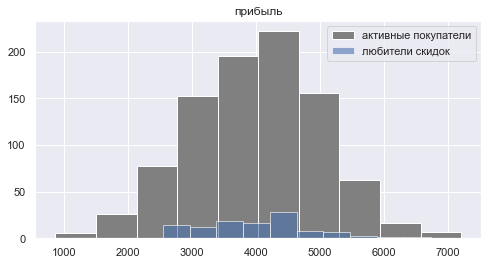

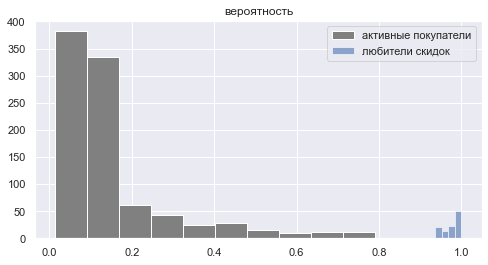

In [108]:
for feature in target_cat.columns.drop('id'):    
    plot_2hist(feature)
    if target_cat[feature].dtype == 'object':
        plt.xticks(rotation='vertical')

In [109]:
df_stat = 0

In [110]:
# выведем информацию о среднем и медиане для любителей скидок и остальных покупателей
df_stat = pd.concat(
    [
     target_cat.describe().T['mean'], 
     other_customers.describe().T['mean']
    ], 
    axis=1
)

df_stat.columns = ['Любители скидок, mean', 'Активные покупатели, mean']
df_stat

,"Любители скидок, mean","Активные покупатели, mean"
id,215553.685185,216178.249729
маркет_актив_6_мес,3.445370,4.561998
маркет_актив_тек_мес,3.935185,4.006515
длительность,617.120370,591.600434
акционные_покупки,0.943333,0.246406
средний_просмотр_категорий_за_визит,2.601852,3.587405
неоплаченные_продукты_штук_квартал,4.296296,2.297503
ошибка_сервиса,3.962963,4.342020
страниц_за_визит,4.083333,9.820847
выручка_текущий_месяц,5253.392593,5200.400434


* Маркетинговая активность за 6 мес: Активные покупатели в среднем на 30% чаще получали звонки, показы рекламы и рассылки. Необходимо пересмотреть параметры для формирования рассылок, предложения акций и скидок.
* Маркетинговая активность в текущем месяце у двух групп покупателей примерно одинаковая.
* Длительность: в среднем любители скидок регистрировались на сайте немного раньше, чем активные покупатели. (617 дней у любителей скидок против 591 дня у активных покупателей). Возможно введение бонусной программы для покупателей, покупающих товар с определенной периодичностью (пр. не реже 1 раза в квартал).
* Акционные покупки: Любители скидок в среднем совершают больше акционных покупок (0.94 против 0.25 у активных покупателей).
* Средний просмотр категорий за визит: Активные покупатели в среднем просматривают больше категорий за визит (3.6 против 2.6 у любителей скидок).
* Неоплаченные продукты: Любители скидок в среднем оставляют больше неоплаченных продуктов (4.3 против 2.3 у активных покупателей). Оценить возможность предложения "горящей скидки" или бонуса, действующего именно сейчас, ограниченное время.
* Страниц за визит: Активные покупатели в среднем просматривают больше страниц за визит (10.0 против 4.0 у любителей скидок). Оптимизация интерфейса пользователя.
* Выручка за последние три месяца примерно одинакова для обеих групп покупателей.
* Время на сайте: Любители скидок в среднем проводят на сайте больше времени.
* Показатели прибыли примерно одинаковы у обеих категорий.

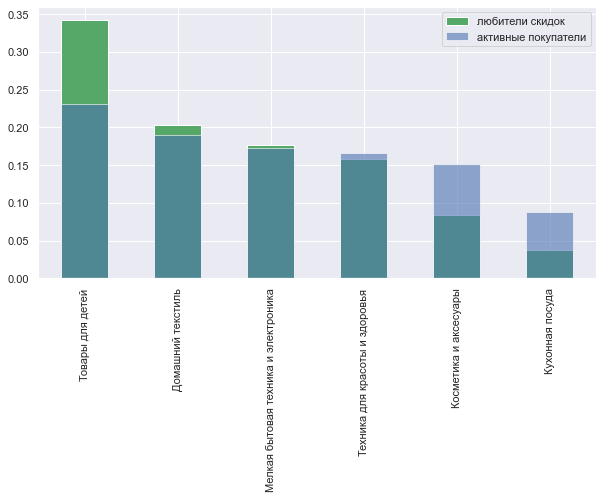

In [111]:
# анализ групп покупателей по категориям товаров
plt.figure(figsize=(10, 5))
target_cat['популярная_категория'].value_counts(
    normalize=True).plot.bar(color='g', label='любители скидок');
other_customers['популярная_категория'].value_counts(
    normalize=True).plot.bar(alpha=0.6, label='активные покупатели');
plt.legend();

Самыми популярными категориями у обеих групп пользователей являются категория "Товары для детей" и "Домашний текстиль". Однако, любители скидок покупают товары из этих категорий гораздо активнее (более половины от всех товаров). Необходима разработка рекомендаций и персонализированных предложений, основанных на предпочитаемых пользователями категориях.

## Шаг 9. Общий вывод.

* Описание задачи: Разработка решения для интернет-магазина, которое поможет увеличить покупательскую активность постоянных клиентов через персонализированные предложения. Для этого необходимо предсказать вероятность снижения покупательской активности клиента в следующие три месяца, выделить сегменты покупателей и разработать для них персонализированные предложения.
* Исходные данные и предобработка: Данные состоят из четырех наборов данных: данные о покупателях, данные о выручке, данные о прибыли и данные о времени нахождения на сайте. В результате предобработки данных сделано следующее: названия признаков в таблицах приведены к змеиному регистру, устранен неявный дубликат в признаке "тип_сервиса" таблицы `df_file`, преобразован тип данных в значении признака "прибыль" таблицы `df_profit`.
* Поиск лучшей модели осуществлялся с помощью алгоритмов, основанных на методе опорных векторов, логистической регрессии, методе k-ближайших соседей и дереве решений. Для выбора лучшей модели была проведена кросс-валидация и подбор гиперпараметров. Качество моделей оценили по метрике ROC-AUC.
* Лучшей моделью стала модель SVC() c ядром 'rbf' с метрикой ROC-AUC, равной 0.944. 
* Необходимо поддерживать активность покупателей сегмента "Любители скидок" с помощью персонализированных предложений, бонусной программы, улучшения системы рекомендаций. Несмотря на скромную активность на сайте, большое количество неоплаченных товаров и отсутствие интереса к товарам без акции, выбранный сегмент интересен сервису, так как приносит такую же прибыль, как и остальные покупатели.